In [2]:
import argparse
import os
import random
import sys
import time
from math import pi
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import numpy as np
import orbslam2
import PIL
import requests
import torch
import torch.nn.functional as F

import habitat
from habitat.config.default import get_config
from habitat.sims.habitat_simulator.actions import HabitatSimActions
from habitat_baselines.config.default import get_config as cfg_baseline
from habitat_baselines.slambased.mappers import DirectDepthMapper
from habitat_baselines.slambased.monodepth import MonoDepthEstimator
from habitat_baselines.slambased.path_planners import DifferentiableStarPlanner
from habitat_baselines.slambased.reprojection import (
    angle_to_pi_2_minus_pi_2 as norm_ang,
)
from habitat_baselines.slambased.reprojection import (
    get_direction,
    get_distance,
    habitat_goalpos_to_mapgoal_pos,
    homogenize_p,
    planned_path2tps,
    project_tps_into_worldmap,
)
from habitat_baselines.slambased.utils import generate_2dgrid

In [2]:
!ln -s /habitat-challenge-data ./data

In [4]:
GOAL_SENSOR_UUID = "pointgoal_with_gps_compass"

def download(url, filename):
    with open(filename, "wb") as f:
        response = requests.get(url, stream=True)
        total = response.headers.get("content-length")
        if total is None:
            f.write(response.content)
        else:
            downloaded = 0
            total = int(total)
            for data in response.iter_content(
                chunk_size=max(int(total / 1000), 1024 * 1024)
            ):
                downloaded += len(data)
                f.write(data)
                done = int(50 * downloaded / total)
                sys.stdout.write(
                    "\r[{}{}]".format("█" * done, "." * (50 - done))
                )
                sys.stdout.flush()
    sys.stdout.write("\n")


def ResizePIL2(np_img, size=256):
    im1 = PIL.Image.fromarray(np_img)
    return np.array(im1.resize((size, size)))


def make_good_config_for_orbslam2(config):
    config.SIMULATOR.AGENT_0.SENSORS = ["RGB_SENSOR", "DEPTH_SENSOR"]
    config.SIMULATOR.RGB_SENSOR.WIDTH = 256
    config.SIMULATOR.RGB_SENSOR.HEIGHT = 256
    config.SIMULATOR.DEPTH_SENSOR.WIDTH = 256
    config.SIMULATOR.DEPTH_SENSOR.HEIGHT = 256
    config.ORBSLAM2.CAMERA_HEIGHT = config.SIMULATOR.DEPTH_SENSOR.POSITION[1]
    config.ORBSLAM2.H_OBSTACLE_MIN = (0.3 * config.ORBSLAM2.CAMERA_HEIGHT)
    config.ORBSLAM2.H_OBSTACLE_MAX = (1.0 * config.ORBSLAM2.CAMERA_HEIGHT)
    config.ORBSLAM2.MIN_PTS_IN_OBSTACLE = (config.SIMULATOR.DEPTH_SENSOR.WIDTH / 2.0)
    return

In [5]:
from habitat_baselines.slambased.reprojection import angle_to_pi_2_minus_pi_2

In [6]:
from habitat_baselines.agents.slam_agents import RandomAgent

In [7]:
class ORBSLAM2Agent(RandomAgent):
    def __init__(self, config, device=torch.device("cuda:0")):
        self.num_actions = config.NUM_ACTIONS
        self.dist_threshold_to_stop = config.DIST_TO_STOP
        self.slam_vocab_path = config.SLAM_VOCAB_PATH
        assert os.path.isfile(self.slam_vocab_path)
        self.slam_settings_path = config.SLAM_SETTINGS_PATH
        assert os.path.isfile(self.slam_settings_path)
        self.slam = orbslam2.System(
            self.slam_vocab_path, self.slam_settings_path, orbslam2.Sensor.RGBD
        )
        self.slam.set_use_viewer(False)
        self.slam.initialize()
        self.device = device
        self.map_size_meters = config.MAP_SIZE
        self.map_cell_size = config.MAP_CELL_SIZE
        self.pos_th = config.DIST_REACHED_TH
        self.next_wp_th = config.NEXT_WAYPOINT_TH
        self.angle_th = config.ANGLE_TH
        self.obstacle_th = config.MIN_PTS_IN_OBSTACLE
        self.depth_denorm = config.DEPTH_DENORM
        self.planned_waypoints = []
        self.mapper = DirectDepthMapper(
            camera_height=config.CAMERA_HEIGHT,
            near_th=config.D_OBSTACLE_MIN,
            far_th=config.D_OBSTACLE_MAX,
            h_min=config.H_OBSTACLE_MIN,
            h_max=config.H_OBSTACLE_MAX,
            map_size=config.MAP_SIZE,
            map_cell_size=config.MAP_CELL_SIZE,
            device=device,
        )
        self.planner = DifferentiableStarPlanner(
            max_steps=config.PLANNER_MAX_STEPS,
            preprocess=config.PREPROCESS_MAP,
            beta=config.BETA,
            device=device,
        )
        self.slam_to_world = 1.0
        self.timestep = 0.1
        self.timing = False
        self.reset()
        return

    def reset(self):
        super(ORBSLAM2Agent, self).reset()
        self.offset_to_goal = None
        self.tracking_is_OK = False
        self.waypointPose6D = None
        self.unseen_obstacle = False
        self.action_history = []
        self.planned_waypoints = []
        self.map2DObstacles = self.init_map2d()
        n, ch, height, width = self.map2DObstacles.size()
        self.coordinatesGrid = generate_2dgrid(height, width, False).to(
            self.device
        )
        self.pose6D = self.init_pose6d()
        self.action_history = []
        self.pose6D_history = []
        self.position_history = []
        self.planned2Dpath = torch.zeros((0))
        self.slam.reset()
        self.cur_time = 0
        self.toDoList = []
        self.waypoint_id = 0
        if self.device != torch.device("cpu"):
            torch.cuda.empty_cache()
        return

    def update_internal_state(self, habitat_observation):
        super(ORBSLAM2Agent, self).update_internal_state(habitat_observation)
        self.cur_time += self.timestep
        rgb, depth = self.rgb_d_from_observation(habitat_observation)
        t = time.time()
        try:
            self.slam.process_image_rgbd(rgb, depth, self.cur_time)
            if self.timing:
                print(time.time() - t, "ORB_SLAM2")
            self.tracking_is_OK = str(self.slam.get_tracking_state()) == "OK"
        except BaseException:
            print("Warning!!!! ORBSLAM processing frame error")
            self.tracking_is_OK = False
        if not self.tracking_is_OK:
            self.reset()
        t = time.time()
        self.set_offset_to_goal(habitat_observation)
        if self.tracking_is_OK:
            trajectory_history = np.array(self.slam.get_trajectory_points())
            self.pose6D = homogenize_p(
                torch.from_numpy(trajectory_history[-1])[1:]
                .view(3, 4)
                .to(self.device)
            ).view(1, 4, 4)
            self.trajectory_history = trajectory_history
            if len(self.position_history) > 1:
                previous_step = get_distance(
                    self.pose6D.view(4, 4),
                    torch.from_numpy(self.position_history[-1])
                    .view(4, 4)
                    .to(self.device),
                )
                if self.action_history[-1] == HabitatSimActions.MOVE_FORWARD:
                    self.unseen_obstacle = (
                        previous_step.item() <= 0.001
                    )  # hardcoded threshold for not moving
        current_obstacles = self.mapper(
            torch.from_numpy(depth).to(self.device).squeeze(), self.pose6D
        ).to(self.device)
        self.current_obstacles = current_obstacles
        self.map2DObstacles = torch.max(
            self.map2DObstacles, current_obstacles.unsqueeze(0).unsqueeze(0)
        )
        if self.timing:
            print(time.time() - t, "Mapping")
        return True

    def init_pose6d(self):
        return torch.eye(4).float().to(self.device)

    def map_size_in_cells(self):
        return int(self.map_size_meters / self.map_cell_size)

    def init_map2d(self):
        return (
            torch.zeros(
                1, 1, self.map_size_in_cells(), self.map_size_in_cells()
            )
            .float()
            .to(self.device)
        )

    def get_orientation_on_map(self):
        self.pose6D = self.pose6D.view(1, 4, 4)
        return torch.tensor(
            [
                [self.pose6D[0, 0, 0], self.pose6D[0, 0, 2]],
                [self.pose6D[0, 2, 0], self.pose6D[0, 2, 2]],
            ]
        )

    def get_position_on_map(self, do_floor=True):
        return project_tps_into_worldmap(
            self.pose6D.view(1, 4, 4),
            self.map_cell_size,
            self.map_size_meters,
            do_floor,
        )

    def act(self, habitat_observation, random_prob=0.1):
        # Update internal state
        t = time.time()
        cc = 0
        update_is_ok = self.update_internal_state(habitat_observation)
        while not update_is_ok:
            update_is_ok = self.update_internal_state(habitat_observation)
            cc += 1
            if cc > 2:
                break
        if self.timing:
            print(time.time() - t, " s, update internal state")
        self.position_history.append(
            self.pose6D.detach().cpu().numpy().reshape(1, 4, 4)
        )
        success = self.is_goal_reached()
        if success:
            action = HabitatSimActions.STOP
            self.action_history.append(action)
            return {"action": action}
        # Plan action
        t = time.time()
        self.planned2Dpath, self.planned_waypoints = self.plan_path()
        if self.timing:
            print(time.time() - t, " s, Planning")
        t = time.time()
        # Act
        if self.waypointPose6D is None:
            self.waypointPose6D = self.get_valid_waypoint_pose6d()
        if (
            self.is_waypoint_reached(self.waypointPose6D)
            or not self.tracking_is_OK
        ):
            self.waypointPose6D = self.get_valid_waypoint_pose6d()
            self.waypoint_id += 1
        action = self.decide_what_to_do()
        # May be random?
        random_action = random.randint(0, self.num_actions - 1)
        what_to_do = np.random.uniform(0, 1, 1)
        if what_to_do < random_prob:
            action = random_action
        if self.timing:
            print(time.time() - t, " s, get action")
        self.action_history.append(action)
        return {"action": action}

    def is_waypoint_good(self, pose6d):
        p_init = self.pose6D.squeeze()
        dist_diff = get_distance(p_init, pose6d)
        valid = dist_diff > self.next_wp_th
        return valid.item()

    def is_waypoint_reached(self, pose6d):
        p_init = self.pose6D.squeeze()
        dist_diff = get_distance(p_init, pose6d)
        reached = dist_diff <= self.pos_th
        return reached.item()

    def get_waypoint_dist_dir(self):
        angle = get_direction(
            self.pose6D.squeeze(), self.waypointPose6D.squeeze(), 0, 0
        )
        dist = get_distance(
            self.pose6D.squeeze(), self.waypointPose6D.squeeze()
        )
        return torch.cat(
            [
                dist.view(1, 1),
                torch.sin(angle).view(1, 1),
                torch.cos(angle).view(1, 1),
            ],
            dim=1,
        )

    def get_valid_waypoint_pose6d(self):
        p_next = self.planned_waypoints[0]
        while not self.is_waypoint_good(p_next):
            if len(self.planned_waypoints) > 1:
                self.planned_waypoints = self.planned_waypoints[1:]
                p_next = self.planned_waypoints[0]
            else:
                p_next = self.estimatedGoalPos6D.squeeze()
                break
        return p_next

    def set_offset_to_goal(self, observation):
        self.offset_to_goal = (
            torch.from_numpy(observation[GOAL_SENSOR_UUID])
            .float()
            .to(self.device)
        )
        self.estimatedGoalPos2D = habitat_goalpos_to_mapgoal_pos(
            self.offset_to_goal,
            self.pose6D.squeeze(),
            self.map_cell_size,
            self.map_size_meters,
        )
        self.estimatedGoalPos6D = planned_path2tps(
            [self.estimatedGoalPos2D],
            self.map_cell_size,
            self.map_size_meters,
            1.0,
        ).to(self.device)[0]
        return

    def rgb_d_from_observation(self, habitat_observation):
        rgb = habitat_observation["rgb"]
        depth = None
        if "depth" in habitat_observation:
            depth = self.depth_denorm * habitat_observation["depth"]
        return rgb, depth

    def prev_plan_is_not_valid(self):
        if len(self.planned2Dpath) == 0:
            return True
        pp = torch.cat(self.planned2Dpath).detach().cpu().view(-1, 2)
        binary_map = self.map2DObstacles.squeeze().detach() >= self.obstacle_th
        obstacles_on_path = (
            binary_map[pp[:, 0].long(), pp[:, 1].long()]
        ).long().sum().item() > 0
        return obstacles_on_path  # obstacles_nearby or  obstacles_on_path

    def rawmap2_planner_ready(self, rawmap, start_map, goal_map):
        map1 = (rawmap / float(self.obstacle_th)) ** 2
        map1 = (
            torch.clamp(map1, min=0, max=1.0)
            - start_map
            - F.max_pool2d(goal_map, 3, stride=1, padding=1)
        )
        return torch.relu(map1)

    def plan_path(self, overwrite=False):
        t = time.time()
        if (
            (not self.prev_plan_is_not_valid())
            and (not overwrite)
            and (len(self.planned_waypoints) > 0)
        ):
            return self.planned2Dpath, self.planned_waypoints
        self.waypointPose6D = None
        current_pos = self.get_position_on_map()
        start_map = torch.zeros_like(self.map2DObstacles).to(self.device)
        start_map[
            0, 0, current_pos[0, 0].long(), current_pos[0, 1].long()
        ] = 1.0
        goal_map = torch.zeros_like(self.map2DObstacles).to(self.device)
        goal_map[
            0,
            0,
            self.estimatedGoalPos2D[0, 0].long(),
            self.estimatedGoalPos2D[0, 1].long(),
        ] = 1.0
        path, cost = self.planner(
            self.rawmap2_planner_ready(
                self.map2DObstacles, start_map, goal_map
            ).to(self.device),
            self.coordinatesGrid.to(self.device),
            goal_map.to(self.device),
            start_map.to(self.device),
        )
        if len(path) == 0:
            return path, []
        if self.timing:
            print(time.time() - t, " s, Planning")
        t = time.time()
        planned_waypoints = planned_path2tps(
            path, self.map_cell_size, self.map_size_meters, 1.0, False
        ).to(self.device)
        return path, planned_waypoints

    def planner_prediction_to_command(self, p_next):
        command = HabitatSimActions.STOP
        p_init = self.pose6D.squeeze()
        d_angle_rot_th = self.angle_th
        pos_th = self.pos_th
        if get_distance(p_init, p_next) <= pos_th:
            return command
        d_angle = angle_to_pi_2_minus_pi_2(
            get_direction(p_init, p_next, ang_th=d_angle_rot_th, pos_th=pos_th)
        )
        if abs(d_angle) < d_angle_rot_th:
            command = HabitatSimActions.MOVE_FORWARD
        else:
            if (d_angle > 0) and (d_angle < pi):
                command = HabitatSimActions.TURN_LEFT
            elif d_angle > pi:
                command = HabitatSimActions.TURN_RIGHT
            elif (d_angle < 0) and (d_angle > -pi):
                command = HabitatSimActions.TURN_RIGHT
            else:
                command = HabitatSimActions.TURN_LEFT
        return command

    def decide_what_to_do(self):
        action = None
        if self.is_goal_reached():
            action = HabitatSimActions.TURN_RIGHT
            return {"action": action}
        if self.unseen_obstacle:
            command = HabitatSimActions.TURN_RIGHT
            return command
        command = HabitatSimActions.TURN_RIGHT
        command = self.planner_prediction_to_command(self.waypointPose6D)
        return command

In [8]:
class SimpleRLEnv(habitat.RLEnv):
    def get_reward_range(self):
        return [-1, 1]

    def get_reward(self, observations):
        return 0

    def get_done(self, observations):
        return self.habitat_env.episode_over

    def get_info(self, observations):
        return self.habitat_env.get_metrics()

In [9]:
def draw_top_down_map(info, heading, output_size):
    top_down_map = maps.colorize_topdown_map(
        info["top_down_map"]["map"], info["top_down_map"]["fog_of_war_mask"]
    )
    original_map_size = top_down_map.shape[:2]
    map_scale = np.array(
        (1, original_map_size[1] * 1.0 / original_map_size[0])
    )
    new_map_size = np.round(output_size * map_scale).astype(np.int32)
    # OpenCV expects w, h but map size is in h, w
    top_down_map = cv2.resize(top_down_map, (new_map_size[1], new_map_size[0]))

    map_agent_pos = info["top_down_map"]["agent_map_coord"]
    map_agent_pos = np.round(
        map_agent_pos * new_map_size / original_map_size
    ).astype(np.int32)
    top_down_map = maps.draw_agent(
        top_down_map,
        map_agent_pos,
        heading - np.pi / 2,
        agent_radius_px=top_down_map.shape[0] / 40,
    )
    return top_down_map

In [10]:
parser = argparse.ArgumentParser()
parser.add_argument(
    "--agent-type",
    default="orbslam2-rgbd",
    choices=["blind", "orbslam2-rgbd", "orbslam2-rgb-monod"],
)
parser.add_argument(
    "--task-config", type=str, default="/habitat-api/configs/tasks/pointnav_rgbd.yaml"
)
args = parser.parse_args("")

In [11]:
config = get_config()
agent_config = cfg_baseline()
config.defrost()
agent_config.defrost()
config.SIMULATOR.SCENE = 'data/scene_datasets/gibson/Aldrich.glb'
config.ORBSLAM2 = agent_config.ORBSLAM2
config.NUM_ACTIONS = 4
config.DIST_TO_STOP = 0.5
for i in list(agent_config.ORBSLAM2.keys()):
    config[i] = agent_config['ORBSLAM2'][i]
config.SLAM_VOCAB_PATH = '/root/3rdparty/ORB_SLAM2/Vocabulary/ORBvoc.txt'
config.SLAM_SETTINGS_PATH = '/habitat-api/habitat_baselines/slambased/data/mp3d3_small1k.yaml'

make_good_config_for_orbslam2(config)

In [12]:
agent = ORBSLAM2Agent(config)

In [15]:
#config_task = get_config("/habitat-api/configs/tasks/pointnav_rgbd.yaml")
config_task = get_config('/habitat-challenge-data/challenge_pointnav2020.local.rgbd.yaml')
config_task.defrost()
config_task.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
config_task.TASK.SENSORS.append("HEADING_SENSOR")
config_task.TASK.SENSORS.append("POINTGOAL_WITH_GPS_COMPASS_SENSOR")
config_task.SIMULATOR.SCENE = 'data/scene_datasets/gibson/Aldrich.glb'
config_task.freeze()
env = SimpleRLEnv(config_task)

2020-02-28 12:31:00,736 Initializing dataset PointNav-v1
2020-02-28 12:31:00,742 initializing sim Sim-v0
2020-02-28 12:31:01,965 Initializing task Nav-v0


In [34]:
import cv2
from habitat.utils.visualizations import maps
def plott(observation,info,env,agent,ii):
    f = plt.figure(figsize=(10,10))
    ax = f.add_subplot(131)
    ax2 = f.add_subplot(132)
    ax3 = f.add_subplot(133)
    ax.set_aspect('equal')
    ax2.set_aspect('equal')
    ax3.set_aspect('equal')

    path_map = torch.zeros_like(agent.map2DObstacles[0][0])
    mapp = torch.zeros((400,400,3)).cuda()
    
    current_pose = agent.get_position_on_map()
    path, planned_path = agent.plan_path()
    print(len(path))
    for ip in path:
        path_map[ip[0].long(),ip[1].long()] = torch.max(agent.map2DObstacles[0][0][:])
    
    mapp[:,:,1] += path_map
    mapp[:,:,0] += agent.map2DObstacles[0][0]
    mapp = mapp.permute(1,0,2)
    shift = 100
    shiftto = 300
    if torch.nonzero(mapp).size()[0]>1:
        shift = min(torch.nonzero(mapp)[:,:2].reshape(1,-1)[0])
        shiftto = max(torch.nonzero(mapp)[:,:2].reshape(1,-1)[0])  
        shift = max(0,shift-10)
        shiftto = min(400,shiftto+10)
    ax.imshow(mapp[:].cpu().numpy()[shift:shiftto,shift:shiftto,:]);
    circ1 = Circle((agent.estimatedGoalPos2D[0,0].long()-shift,agent.estimatedGoalPos2D[0,1].long()-shift),3,color='yellow')
    circ2 = Circle((current_pose[0,0].long()-shift,current_pose[0,1].long()-shift),3,color='white')
    top_down_map = draw_top_down_map(info, observation["heading"][0], observation["rgb"].shape[0])
    ax.add_patch(circ1)
    ax.add_patch(circ2)
    ax2.imshow(observation['depth'][:,:,0])
    ax.set_title('Distance_to_goal '+str(info['distance_to_goal']))
    ax2.set_title('Spl  '+str(info['spl']))
    ax3.imshow(top_down_map)
    #gray = cv2.normalize(observation['depth'][:,:,0], None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    #gray_3c = cv2.merge([gray, gray, gray])
    folder = 'image_slam'
    f.savefig(folder+"/file%02d.png" % ii)
    plt.show()

In [35]:
!rm -r ./image_slam
!mkdir ./image_slam
agent.reset()
observation = env.reset()
done = False
info = {}
info['distance_to_goal'] = 0
dones = []
actions = []
ii = 0

23


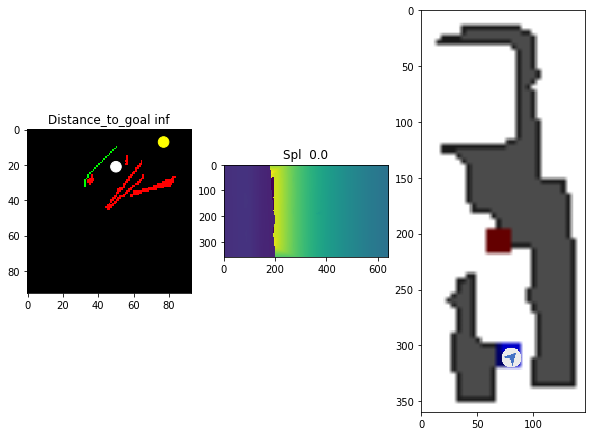

In [38]:
from IPython.display import clear_output
while not done:
    action = agent.act(observation)
    print(action['action'])
    if action['action']==0 and info['distance_to_goal']>0.3:
        action['action']=3
    # if env.get_metrics()['distance_to_goal']>0.02:
    #     action['action']=3    
    actions.append(action['action'])
    dones.append(done)
    if not done:
        observation, reward, done, info = env.step(action['action'])
    else:
        print('EPISODE IS OVER')
    ii+=1
    clear_output()
    plott(observation,info,env,agent,ii);

In [89]:
import subprocess
!rm video_name.mp4
os.chdir('/root/image_slam')
subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        '../video_name.mp4'
    ])
os.chdir('/root')

In [ ]:
action = agent.act(observation)
print(action['action'])
if action['action']==0 and env.get_metrics()['distance_to_goal']>0.2:
    action['action']=3
#if action['action']!=5:
#    action['action']=3
actions.append(action['action'])
dones.append(env._episode_over)
observation = env.step(action)
print(actions[-2:],'\t',dones[-2:])
print(agent.get_position_on_map())
print(env.get_metrics())

In [ ]:
shift = 100
current_pose = agent.get_position_on_map()
start_map = torch.zeros_like(agent.map2DObstacles[0][0])
start_map[current_pose[0,0].long(),current_pose[0,1].long()] = torch.max(agent.map2DObstacles[0][0][:])
path, planned_path = agent.plan_path()
path_map = torch.zeros_like(agent.map2DObstacles[0][0])
for i in path:
    path_map[i[0].long(),i[1].long()] = torch.max(agent.map2DObstacles[0][0][:])
mapp = torch.zeros((400,400,3)).cuda()
mapp[:,:,1] += path_map
mapp[:,:,0] += agent.map2DObstacles[0][0]
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.set_aspect('equal')
ax2.set_aspect('equal')
ax.imshow(mapp[:].cpu().numpy()[shift:,shift:,:]);
circ1 = Circle((agent.estimatedGoalPos2D[0,0].long()-shift,agent.estimatedGoalPos2D[0,1].long()-shift),3,color='yellow')
circ2 = Circle((current_pose[0,0].long()-shift,current_pose[0,1].long()-shift),3,color='white')
ax.add_patch(circ1)
ax.add_patch(circ2)
ax2.imshow(observation['depth'][:,:,0])
plt.show()